## Big Data -> Big Money?
#### ~Regression with Spark

The aim of this project is to explain the trends in stock prices for different stocks and predict the closing prices using historical data for different stocks. Here we build a Linear Regression model using Spark to predict the closing price of stocks using different variables created below as explanatory variables.

In [1]:
#Importing the required libraries
from pyspark.sql import SparkSession
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml import regression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as fn
import pickle as pkl
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

The data we use here is a [dataset](https://www.quandl.com/databases/SEP/data) obtained from Quandl about historical data of stocks and related industry data.

A lot of cleaning and transformation including droping, type conversion, bucketing and one-hot vectorization was required to make the data usable. These steps haven't been shown here to make the notebook concise.

Our data consisted stock data for 16 thousand stocks. We only work with stocks from the S&P 500 list. 
Since the size of this data set was in GBs it was difficult to use pandas.
As pandas doesn't work well with data of this size. 
Hence our go to is Spark which uses distributed computing to solve this problem.

In [2]:
#Reading our cleaned and subsetted dataframe in Spark
stock_df = spark.read.csv('snp500datafinal.csv', header=True, inferSchema=True)

First we build our model for a single stock and then build a function to work with any stock.

In [3]:
#Selecting a single stock(Amazon) to work with
df = stock_df.where(fn.col('ticker')=='AMZN')

Next we create different explanatory variables from existing ones which help us explain trends in closing price.

In [4]:
#Daily return: Calculated as ((Closing/Opening)-1)*100
df = df.withColumn("daily_return", (((fn.col("close") / fn.col("open"))-1)*100))

#Lag 1: Closing Price from day before
w1 = Window().rowsBetween(-1,-1)
df = df.withColumn("l1", fn.avg(fn.col('close')).over(w1))
#Lag 2: Closing Price from two days before
w2 = Window().rowsBetween(-2,-2)
df = df.withColumn("l2", fn.avg(fn.col('close')).over(w2))
#Lag 5: Closing Price from five days before
w5 = Window().rowsBetween(-5,-5)
df = df.withColumn("l5", fn.avg(fn.col('close')).over(w5))

#3 day Moving Average: Average closing price over past three days 
w3 = Window().rowsBetween(-3,-1)
df = df.withColumn("3daymav", fn.avg(fn.col('l1')).over(w3))
#7 day Moving Average: Average closing price over past seven days
w7 = Window().rowsBetween(-7,-1)
df = df.withColumn("7daymav", fn.avg(fn.col('l1')).over(w7))

#Volume lag: Volume from day before 
wv = Window().rowsBetween(-1,-1)
df = df.withColumn("volume1", fn.avg(fn.col('volume')).over(wv))

#Momentum: Calculated as (Lag1-Lag5)/4
df = df.withColumn("momentum",(fn.col('l1')-fn.col('l5'))/4)

#rate of change: Calculated as Lag1/Lag5
df = df.withColumn("roc",fn.col('l1')/fn.col('l5'))

In [5]:
#Due to moving average calculations inital rows will have null values, hence we drop these rows first
df1 = df.limit(5)     
df = df.subtract(df1)
#Let's take a look at our final data
df.select('ticker','date','7daymav','l1', 'l2', 'momentum','roc','3daymav','volume1','close').show(5)

+------+----------+------------------+------+-------+--------------------+------------------+------------------+---------+------+
|ticker|      date|           7daymav|    l1|     l2|            momentum|               roc|           3daymav|  volume1| close|
+------+----------+------------------+------+-------+--------------------+------------------+------------------+---------+------+
|  AMZN|09-01-2013|         260.84975|266.38|268.459|  2.2674999999999983|1.0352493101706113| 262.0296666666666|3010700.0|266.35|
|  AMZN|10-01-2013|          261.9558|266.35| 266.38|  1.9675000000000011| 1.030447229959765|264.66299999999995|2265600.0|265.34|
|  AMZN|11-01-2013|262.68816666666663|265.34| 266.35|  1.5474999999999994|1.0238857804360408|           267.063|2863400.0|267.94|
|  AMZN|14-01-2013|263.06699999999995|267.94| 265.34|-0.12975000000000136|0.9980667438975784| 266.0233333333333|2413300.0|272.73|
|  AMZN|15-01-2013| 264.5855714285714|272.73| 267.94|  1.5875000000000057|1.02383812598543

Train-test split: We now create a Train-test split for cross-validation purposes. However, rather than shuffling the data randomly for the split, since we are dealing with time series data we make this split mainting the temporal aspect of the data and slicing using time as follows.

In [6]:
#We create a new column called 'id' to split our data to maintain the temporal aspect of our data
#We use a 80-20 training-testing split
df = df.withColumn("id",fn.monotonically_increasing_id())
length = df.count()
itrain = int(0.8*length) 
#splitting using 'id' variable
train = df.where(fn.col('id')<itrain) 
valid = df.where(fn.col('id')>=itrain)

Next we build a Linear Regression pipeline as follows and fit it on our training data.

In [7]:
from pyspark.ml import regression
lr = Pipeline(stages = [
    feature.VectorAssembler(inputCols=['volume1','7daymav','l1','l2','momentum','roc','3daymav'],outputCol='features'),
    regression.LinearRegression(featuresCol='features', labelCol='close')
]).fit(train)

Let's analyze our regression model by looking at the intercepts, p-values and r2.

In [8]:
trainingSummary = lr.stages[-1].summary
coefficients = list(lr.stages[-1].coefficients) #List of coefficients
coefficients.append(lr.stages[-1].intercept)
pValues = list(trainingSummary.pValues) #List of p-values
variables = list(lr.stages[0].getInputCols()) #List of explanatory variables
variables.append('intercept')
summary = pd.DataFrame({'variables':variables,'coefficients':coefficients,'pValues':pValues})
print(summary)
print("r2: %f" % trainingSummary.r2)

   variables  coefficients   pValues
0    volume1 -1.896874e-07  0.120924
1    7daymav -9.168780e-05  0.998641
2         l1  1.056035e+00  0.000000
3         l2 -4.275298e-02  0.425828
4   momentum -8.167050e-02  0.709721
5        roc -1.005019e+01  0.610148
6    3daymav -1.274077e-02  0.843323
7  intercept  1.117998e+01  0.572210
r2: 0.998600


We use RMSE as our validation metrics to measure performance.

In [9]:
rmse = fn.sqrt(fn.mean((fn.col('close') - fn.col('prediction'))**2)).alias('rmse')

In [10]:
#RMSE on train
lr.transform(train).select(rmse).show()

+-----------------+
|             rmse|
+-----------------+
|8.998881060258977|
+-----------------+



In [11]:
#Getting predictions and targets 
pred = lr.transform(train).select('prediction').collect()
label = lr.transform(train).select('close').collect()

Let's look at how our model performs visually on the training data

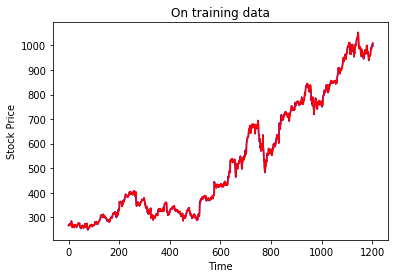

In [12]:
plt.plot(label,'-b',label='Test')
plt.plot(pred,'-r',label='Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('On training data')
plt.show()

Testing performance:

In [13]:
#RMSE on testing data
r = lr.transform(valid).select(rmse).show()

+------------------+
|              rmse|
+------------------+
|34.551835140591464|
+------------------+



In [14]:
pred = lr.transform(valid).select('prediction').collect()
label = lr.transform(valid).select('close').collect()

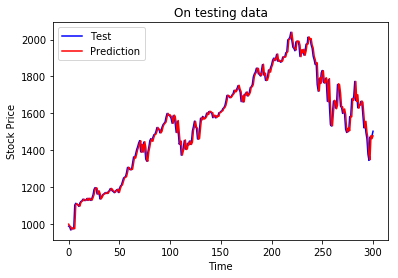

In [15]:
plt.plot(label,'-b',label='Test')
plt.plot(pred,'-r',label='Prediction')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('On testing data')
plt.show()

We barely notice the difference between actual values and predictions, this visualization can be misleading as one of our variables is the closing price from day before which sets a good level for predictions and makes them closer to the actual value.

Finally we create functions to do the above tasks for different stocks.

In [16]:
def make_variables(df):
    df = df.withColumn("daily_return", (((fn.col("close") / fn.col("open"))-1)*100))
    w2 = Window().rowsBetween(-1,-1)
    df = df.withColumn("l1", fn.avg(fn.col('close')).over(w2))
    w3 = Window().rowsBetween(-3,-1)
    df = df.withColumn("3daymav", fn.avg(fn.col('l1')).over(w3))
    w4 = Window().rowsBetween(-7,-1)
    df = df.withColumn("7daymav", fn.avg(fn.col('l1')).over(w4))
    w5 = Window().rowsBetween(-2,-2)
    df = df.withColumn("l2", fn.avg(fn.col('close')).over(w5))
    w6 = Window().rowsBetween(-5,-5)
    df = df.withColumn("l5", fn.avg(fn.col('close')).over(w6))
    w7 = Window().rowsBetween(-1,-1)
    df = df.withColumn("volume1", fn.avg(fn.col('volume')).over(w7))
    df = df.withColumn("momentum",(fn.col('l1')-fn.col('l5'))/4)
    df = df.withColumn("roc",fn.col('l1')/fn.col('l5'))
    return df
    
#This function fits the data to the LR pipeline and returns predictions on testing data
def make_model(df,model_name,lr_pipeline):
  try:
    df1 = df.limit(5)     
    df = df.subtract(df1)
    df = df.withColumn("id",fn.monotonically_increasing_id())
    size = df.count()
    itrain = int(0.8*size)
    train = df.where(fn.col('id')<itrain)
    valid = df.where(fn.col('id')>=itrain)
    lr = lr_pipeline.fit(train)
    rmse = fn.sqrt(fn.mean((fn.col('close') - fn.col('prediction'))**2)).alias('rmse')
    rrmse = lr.transform(valid).select(rmse).collect()[0][0]
    results.append({"ticker":model_name,"rmse":rrmse})
    pred = lr.transform(valid).select('prediction').collect()
    label = lr.transform(valid).select('close').collect()
    return pred
  except IndexError:
    failed.append(model_name)
  except ValueError:
    failed.append(model_name)

In [17]:
#Regression pipeline
lr_pipeline = Pipeline(stages = [
    feature.VectorAssembler(inputCols=['volume1','7daymav','l1','l2','momentum','roc','3daymav'],outputCol='features'),
    regression.LinearRegression(featuresCol='features', labelCol='close')
])
#List to store results
results_pred = []
results = []

In [18]:
#Here we use the above functions to create models of multiple stocks 
for val,x in enumerate(['AMZN','AAPL','EXPE','CVS','BAC','GOOGL']):
  df = stock_df.where(fn.col('ticker')==x)
  print(val+1,x)
  df = make_variables(df)
  pred = make_model(df,x,lr_pipeline)
  results_pred.append({"ticker":x,"predictions":pred})

1 AMZN
2 AAPL
3 EXPE
4 CVS
5 BAC
6 GOOGL


Let's look at how regression performs on these stocks.

In [19]:
results

[{'ticker': 'AMZN', 'rmse': 34.551835140591464},
 {'ticker': 'AAPL', 'rmse': 3.1902880796726913},
 {'ticker': 'EXPE', 'rmse': 2.649589734796542},
 {'ticker': 'CVS', 'rmse': 1.3657166225107158},
 {'ticker': 'BAC', 'rmse': 0.4369531000072836},
 {'ticker': 'GOOGL', 'rmse': 18.33497694716903}]

Thus as a conclusion we see simple linear regression has varying results on stocks with RMSE on testing data being less for certain stocks and higher for others. The RMSE can also be given context by looking at the closing prices for different stocks. For example, Amazon has higher stock price(~2k USD) in comparison to Bank of America (BAC)(~50 USD) which explains the relatively higher RMSE for the former.